## Classification results

In [57]:
import pandas as pd

results = []
for i in range(1,12):
    results.append(pd.read_csv(f'data/res_extended/subject_{i}_extended_results.csv'))

results_df = pd.concat(results)

In [58]:
results_df.to_csv(f'all_subjects_classification_extended_results.csv', index=False)

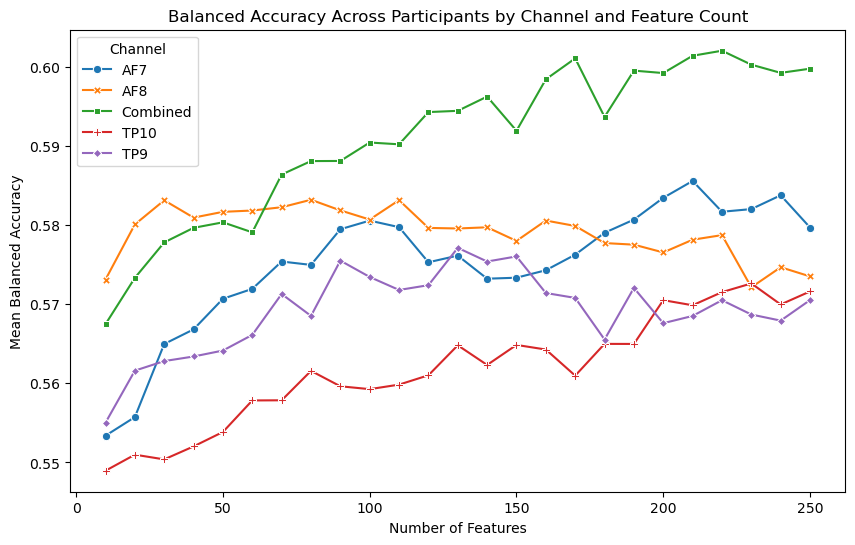

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean Balanced Accuracy
mean_bal_acc = results_df[(results_df['Metric'] == 'test_acc')
 #&(results_df['Subject'].isin([2]))
 #& (~results_df['Subject'].isin([2, 9, 5]))
].groupby(['Channel', 'Num_Features'])['Value'].mean().reset_index()
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_bal_acc, x='Num_Features', y='Value', hue='Channel', style='Channel', markers=True, dashes=False)
plt.title('Balanced Accuracy Across Participants by Channel and Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Mean Balanced Accuracy')
plt.legend(title='Channel')
plt.show()

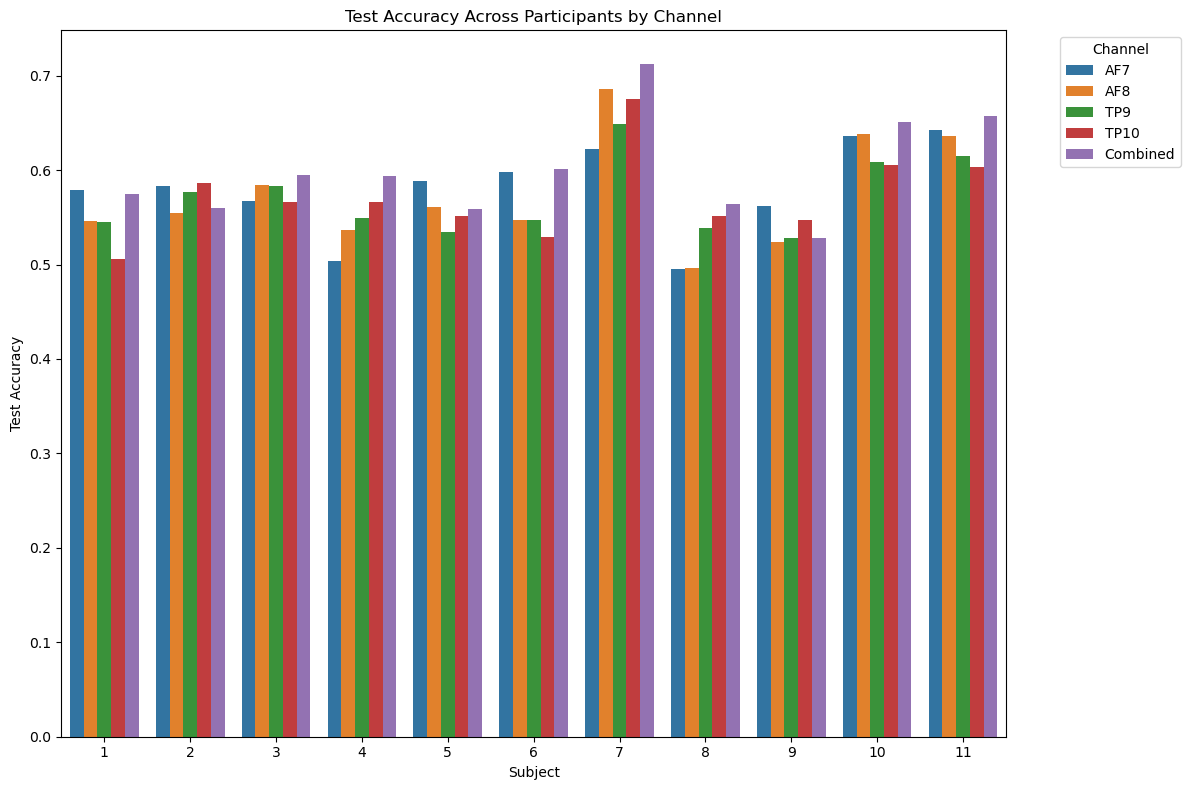

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = results_df[(results_df['Metric'] == 'test_acc') 
& (results_df['Num_Features'] == 250)
]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
sns.barplot(data=plot_data, x='Subject', y='Value', hue='Channel', errorbar=None)

# Adding plot title and labels
plt.title('Test Accuracy Across Participants by Channel')
plt.xlabel('Subject')
plt.ylabel('Test Accuracy')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


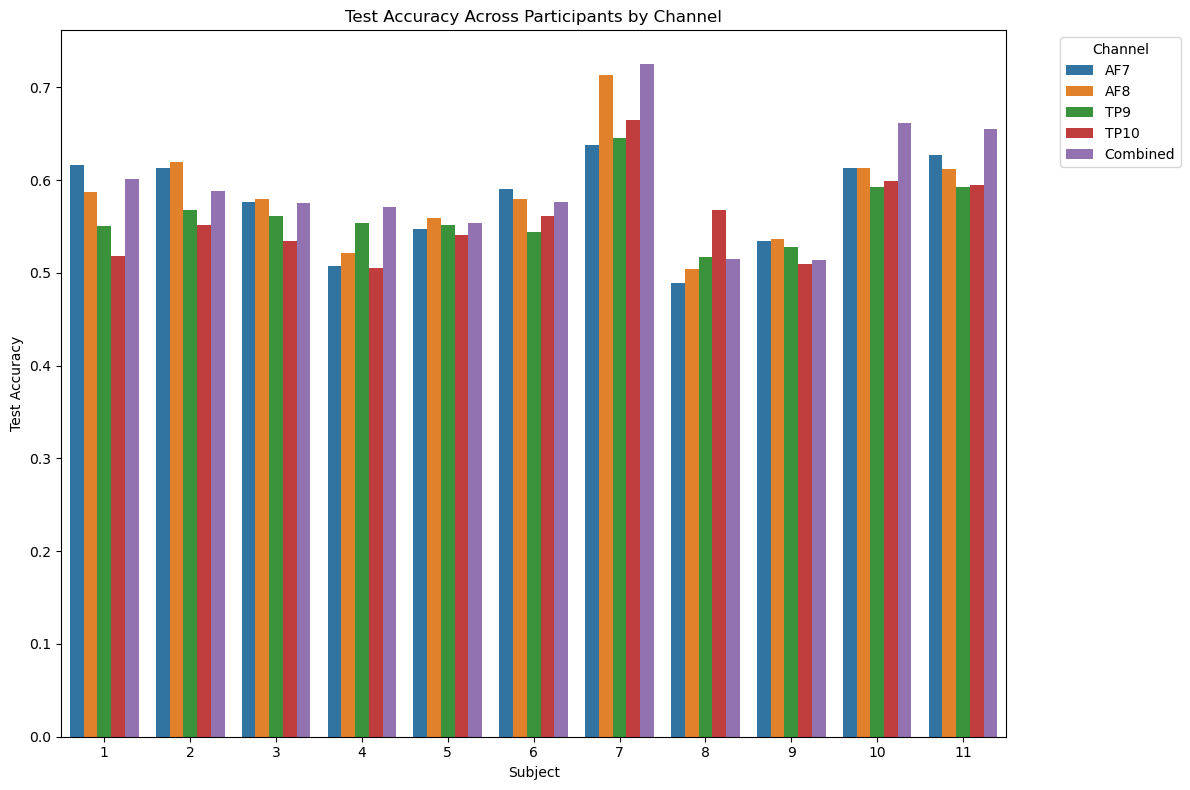

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = results_df[(results_df['Metric'] == 'test_acc') 
& (results_df['Num_Features'] == 250)
]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
sns.barplot(data=plot_data, x='Subject', y='Value', hue='Channel', errorbar=None)

# Adding plot title and labels
plt.title('Test Accuracy Across Participants by Channel')
plt.xlabel('Subject')
plt.ylabel('Test Accuracy')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [100]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame
# Filter data for 'test_acc' metric, required channels, and excluding specific subjects
channels = ['AF7', 'AF8', 'Combined']
filtered_data = results_df[(results_df['Metric'] == 'test_acc') & 
                           (results_df['Channel'].isin(channels))
                        #& (~results_df['Subject'].isin([ 5, 9]))
                            ]

# Prepare a dictionary to store results
wilcoxon_results = {'Num_Features': [], 'Comparison': [], 'Statistic': [], 'P-Value': []}

# Group by Num_Features to perform tests
grouped = filtered_data.groupby('Num_Features')

for name, group in grouped:
    combined_data = group[group['Channel'] == 'Combined']['Value']
    af7_data = group[group['Channel'] == 'AF7']['Value']
    af8_data = group[group['Channel'] == 'AF8']['Value']
    
    if len(combined_data) > 1 and len(af7_data) > 1:
        stat, p_value = wilcoxon(combined_data, af7_data, alternative='two-sided', zero_method='wilcox')
        wilcoxon_results['Num_Features'].append(name)
        wilcoxon_results['Comparison'].append('Combined vs AF7')
        wilcoxon_results['Statistic'].append(stat)
        wilcoxon_results['P-Value'].append(p_value)
        
    if len(combined_data) > 1 and len(af8_data) > 1:
        stat, p_value = wilcoxon(combined_data, af8_data, alternative='two-sided', zero_method='wilcox')
        wilcoxon_results['Num_Features'].append(name)
        wilcoxon_results['Comparison'].append('Combined vs AF8')
        wilcoxon_results['Statistic'].append(stat)
        wilcoxon_results['P-Value'].append(p_value)

# Convert results to DataFrame for easier reading and rename to avoid confusion
significance_df = pd.DataFrame(wilcoxon_results)

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(data=significance_df, x='Num_Features', y='P-Value', hue='Comparison')
plt.title('P-Values for Wilcoxon Test Between Combined and Channels AF7 & AF8')
plt.ylabel('P-Value')
plt.xlabel('Number of Features')
plt.axhline(0.05, color='red', linestyle='--')  # Significance threshold line
plt.legend(title='Comparison')
plt.show()

KeyError: 'Metric'

## Feature importance

In [109]:
mean_correlation.to_csv(f'all_subjects_mean_correlations.csv', index=False)

In [110]:
mean_correlation

,channel,band,feature_type,window_shift,subject_id,mean_correlation
0,AF7,alpha,approx_entropy,win-1,1,-0.006969
1,AF7,alpha,approx_entropy,win-2,1,0.003487
2,AF7,alpha,approx_entropy,win-3,1,0.009546
3,AF7,alpha,approx_entropy,win-4,1,0.001013
4,AF7,alpha,approx_entropy,win-5,1,0.008792
...,...,...,...,...,...,...
995,TP9,theta,total_variation,win-6,11,-0.198629
996,TP9,theta,total_variation,win-7,11,-0.194484
997,TP9,theta,total_variation,win-8,11,-0.196822
998,TP9,theta,total_variation,win-9,11,-0.185234


In [104]:
import pandas as pd
import numpy as np
from scipy.signal import iirnotch, filtfilt, butter
from IPython.display import clear_output

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, train
#for subject_id in range(1,12):
subject_id = 10

eeg_data_1 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

for channel in channels:
    # NORMAL
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])
    # ARTIFACTS
    fs = 256
    f0 = 50
    quality_factor = 30
    b, a = iirnotch(f0, quality_factor, fs)
    eeg_data.loc[:, f'{channel}_filt'] = filtfilt(b, a, eeg_data[f'{channel}_normal'])
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_filt']) 
    # BANDPASS
    lowcut = 0.5
    highcut = 50.0
    filter_order = 5
    nyquist_freq = 0.5 * fs
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    eeg_data.loc[:, [f'{channel}_bandpassed']] = filtfilt(b, a, eeg_data[f'{channel}_artif_removed'])

# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [#1, 
              2,
              3
             ]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

combined_features_df = pd.concat([
#    features_t1, 
   features_t2, 
   features_t3
], ignore_index=True)

12/12 Done


In [106]:
from scipy.stats import pearsonr

# Remove the label column from feature columns
features = combined_features_df.columns[:-1]
label = combined_features_df['in_the_zone']

# Parse feature names
def parse_feature_name(name):
    parts = name.split('_')
    channel = parts[0]
    band = parts[1]
    feature = '_'.join(parts[2:-1])
    window = parts[-1]
    return channel, band, feature, window

# Compute correlation for each feature and store results
results = []
for feature in features:
    correlation, _ = pearsonr(combined_features_df[feature], label)
    channel, band, feature_type, window = parse_feature_name(feature)
    results.append({
        'channel': channel,
        'band': band,
        'feature_type': feature_type,
        'window_shift': window,
        'correlation': correlation,
        'subject_id': subject_id  # predefined subject ID
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate mean correlation for each channel, band, feature type, and window
mean_correlations = results_df.groupby(['channel', 'band', 'feature_type', 'window_shift', 'subject_id']).agg(
    mean_correlation=pd.NamedAgg(column='correlation', aggfunc='mean')
).reset_index()

mean_correlations.head(), mean_correlations.shape

(  channel   band    feature_type window_shift  subject_id  mean_correlation
 0     AF7  alpha  approx_entropy        win-1          11          0.017029
 1     AF7  alpha  approx_entropy        win-2          11          0.022922
 2     AF7  alpha  approx_entropy        win-3          11          0.032379
 3     AF7  alpha  approx_entropy        win-4          11          0.041897
 4     AF7  alpha  approx_entropy        win-5          11          0.041592,
 (1000, 6))

In [107]:
mean_correlations.to_csv(f'mean_correlation_subject_{subject_id}.csv', index=False)

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame to separate out the three different heatmap configurations
df_a = mean_correlations[mean_correlations['feature_type'].isin(['approx_entropy', 'total_variation', 'standard_deviation', 'energy', 'skewness'])]
df_b = df_a.copy()
df_c = mean_correlations.copy()

# Convert 'window_shift' to integer for sorting
df_a['window_shift'] = df_a['window_shift'].str.replace('win-', '').astype(int)
df_b['window_shift'] = df_b['window_shift'].str.replace('win-', '').astype(int)
df_c['window_shift'] = [1]*len(df_c)  # Dummy value for aggregation

# Pivot the data for heatmap
heatmap_data_a = df_a.pivot_table(index=['channel', 'band'], columns='window_shift', values='mean_correlation')
heatmap_data_b = df_b.pivot_table(index=['channel', 'feature_type'], columns='window_shift', values='mean_correlation')
heatmap_data_c = df_c.pivot_table(index=['channel', 'feature_type'], columns='band', values='mean_correlation')

# Sort the index and columns to match the order in the example
sorter_band = ['gamma', 'beta', 'alpha', 'theta', 'delta']
sorter_feature = ['approx_entropy', 'total_variation', 'standard_deviation', 'energy', 'skewness']
heatmap_data_a = heatmap_data_a.loc[pd.IndexSlice[:, sorter_band], :]
heatmap_data_b = heatmap_data_b.loc[pd.IndexSlice[:, sorter_feature], :]
heatmap_data_c = heatmap_data_c.loc[pd.IndexSlice[:, sorter_feature], sorter_band]

# Facet grid of heatmaps
fig, axes = plt.subplots(4, 3, figsize=(20, 16))  # 4 rows for the channels, 3 columns for the heatmaps

# Define the channels
channels = mean_correlations['channel'].unique()

for i, channel in enumerate(channels):
    # Heatmap a)
    sns.heatmap(heatmap_data_a.loc[channel].fillna(0), ax=axes[i, 0], cbar=i == 0, cbar_ax=None if i else axes[:, 0],
                square=False, aspect=2, cmap='viridis')
    axes[i, 0].set_title(f'Channel {channel} - Feature Type by Sliding Window (a)')
    
    # Heatmap b)
    sns.heatmap(heatmap_data_b.loc[channel].fillna(0), ax=axes[i, 1], cbar=i == 0, cbar_ax=None if i else axes[:, 1],
                square=False, aspect=2, cmap='viridis')
    axes[i, 1].set_title(f'Channel {channel} - Feature Type by Band (b)')
    
    # Heatmap c)
    sns.heatmap(heatmap_data_c.loc[channel].fillna(0), ax=axes[i, 2], cbar=i == 0, cbar_ax=None if i else axes[:, 2],
                square=True, aspect=1, cmap='viridis')
    axes[i, 2].set_title(f'Channel {channel} - Band by Sliding Window (c)')

# Adjust layout
plt.tight_layout()
plt.show()


ValueError: invalid literal for int() with base 10: 'win0'

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# First, let's create a mapping for the sliding window shift to ensure correct ordering from 0 to 9
# Since the sliding window shift in the data comes in the format 'win-X', we need to extract the numerical part
# and convert it to an integer to ensure correct sorting.
mean_correlations['window_shift_numeric'] = mean_correlations['window_shift'].str.extract('win(-?\d+)', expand=False).astype(int)
mean_correlations = mean_correlations.sort_values('window_shift_numeric')

# Now we can create pivot tables for each of the heatmap configurations a), b), and c)

# a) Frequency band and sliding window shift
pivot_a = mean_correlations.pivot_table(
    index=['band'], 
    columns=['window_shift_numeric'], 
    values='mean_correlation', 
    aggfunc='mean'
).loc[['gamma', 'beta', 'alpha', 'theta', 'delta']]  # Ensure the order of bands

# b) Feature type and sliding window shift
pivot_b = mean_correlations.pivot_table(
    index=['feature_type'], 
    columns=['window_shift_numeric'], 
    values='mean_correlation', 
    aggfunc='mean'
).loc[['approx_entropy', 'total_variation', 'standard_deviation', 'energy', 'skewness']]  # Order of feature types

# c) Feature type and frequency band
pivot_c = mean_correlations.pivot_table(
    index=['feature_type'], 
    columns=['band'], 
    values='mean_correlation', 
    aggfunc='mean'
).loc[['approx_entropy', 'total_variation', 'standard_deviation', 'energy', 'skewness'],
      ['gamma', 'beta', 'alpha', 'theta', 'delta']]  # Order of both axes

# Define a function to plot a heatmap with appropriate aspect ratio and color
def plot_heatmap(pivot_table, aspect_ratio, ax):
    sns.heatmap(pivot_table, ax=ax, cmap='viridis', cbar=True, annot=True, fmt=".2f",
                cbar_kws={'label': 'Mean Correlation'})
    ax.set_aspect(aspect_ratio)

# Set up the figure for a facet grid with subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

# Plot heatmaps for each channel in a facet grid
channels = ['AF7', 'AF8', 'TP9', 'TP10']
for i, channel in enumerate(channels):
    # Filter the DataFrame for the current channel
    channel_data = mean_correlations[mean_correlations['channel'] == channel]

    # Recreate pivot tables for the current channel
    channel_pivot_a = channel_data.pivot_table(
        index=['band'], 
        columns=['window_shift_numeric'], 
        values='mean_correlation', 
        aggfunc='mean'
    ).loc[['gamma', 'beta', 'alpha', 'theta', 'delta']]
    
    channel_pivot_b = channel_data.pivot_table(
        index=['feature_type'], 
        columns=['window_shift_numeric'], 
        values='mean_correlation', 
        aggfunc='mean'
    ).loc[['approx_entropy', 'total_variation', 'standard_deviation', 'energy', 'skewness']]
    
    channel_pivot_c = channel_data.pivot_table(
        index=['feature_type'], 
        columns=['band'], 
        values='mean_correlation', 
        aggfunc='mean'
    ).loc[['approx_entropy', 'total_variation', 'standard_deviation', 'energy', 'skewness'],
          ['gamma', 'beta', 'alpha', 'theta', 'delta']]
    
    # Plot the heatmaps
    plot_heatmap(channel_pivot_a, 'auto', axs[i, 0])
    plot_heatmap(channel_pivot_b, 2, axs[i, 1])
    plot_heatmap(channel_pivot_c, 1, axs[i, 2])

    # Set the titles for the first row of the grid
    if i == 0:
        axs[i, 0].set_title('a) Frequency Band and Window Shift')
        axs[i, 1].set_title('b) Feature Type and Window Shift')
        axs[i, 2].set_title('c) Feature Type and Frequency Band')

# Set the subtitles for the grid rows
for i, ax in enumerate(axs[:,0]):
    ax.set_ylabel(channels[i], rotation=0, size='large', labelpad=60)

plt.tight_layout()
plt.show()


KeyError: 'mean_correlation'